# Название проекта
Определение стоимости автомобиля
# Описание проекта
Нам необходимо проанализировать датасет с характеристиками автомобилей и на основе него создать прототип модели машинного обучения, определяющего стоимость автомобиля. Для этого нам необходимо провести подготовку данных, где определимся что делать с пропусками, пиковыми значениями, поменяем формат столбцов, если это необходимо и подготовим данные перед загрузкой в модель. После этого обучим модели и проведем анализ их эффективности с целью выбора наиболее подходящей.
#Цель проекта
Создание прототипа модели машинного обучения, определяющего стоимость автомобиля


## Подготовка данных

Загрузим необходимые билиотеки и наш файл

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer
from time import time

In [ ]:
data = pd.read_csv('/datasets/autos.csv')

Теперь посмотрим что из себя представляют наши данные

In [ ]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Думаю не все колонки будут для нас необходимы, например такие как даты анкеты, выгрузки и активноости пользователя, месяц регистрации, количество фотографий, почтовый индекс. Удалим их в конце исследования, а пока посмотрим форматы данных, пропуски и дубликаты.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

В датасете 354369 строк, в предыдущих исследованиях было меньше, но нас это не пугает.

Менять данные не имеет смысла, так как все нам подходит.

Посмотрим пропуски в целом и в долях.

In [ ]:
data.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [ ]:
pd.DataFrame(round(data.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
DateCrawled,0.000000
Price,0.000000
VehicleType,11.000000
RegistrationYear,0.000000
Gearbox,6.000000
Power,0.000000
Model,6.000000
Kilometer,0.000000
RegistrationMonth,0.000000
FuelType,9.000000


20% пропусков в колонке с ремонтом, в целом это неудивительно, люди предпочитают скрывать эту информацию. Посмотрим поближе, кто оставил эту колонку пустой.

In [ ]:
data.loc[data['Repaired'].isna()].sort_values('RegistrationYear').tail()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
151228,2016-03-20 19:53:26,0,NaN,9999,NaN,0,NaN,10000,7,NaN,mazda,NaN,2016-03-20 00:00:00,0,40822,2016-03-20 19:53:26
62395,2016-03-16 23:54:17,55,NaN,9999,NaN,0,other,10000,0,NaN,volkswagen,NaN,2016-03-16 00:00:00,0,38524,2016-03-20 07:46:23
227462,2016-03-14 12:51:55,2850,NaN,9999,NaN,0,other,10000,0,NaN,fiat,NaN,2016-03-14 00:00:00,0,17335,2016-04-05 13:15:26
224832,2016-03-23 16:52:02,0,NaN,9999,NaN,0,NaN,10000,0,NaN,volkswagen,NaN,2016-03-23 00:00:00,0,9437,2016-03-23 16:52:02
60079,2016-03-21 01:01:41,0,NaN,9999,NaN,0,NaN,10000,0,NaN,mazda,NaN,2016-03-21 00:00:00,0,40822,2016-03-22 12:16:30


Такое ощущение что эти строки шутки ради. Много пропусков, а год регистрации встречается и 9999. По сути эти данные бессмысленны для обучения, при таком количестве пропусков невозможно что либо адекватное вычленить.
Будем разбираться с этим позже.

Посмотрим дубликаты и удалим их

In [ ]:
data.duplicated().sum()

4

In [ ]:
data = data.drop_duplicates()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354365 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354365 non-null  object
 1   Price              354365 non-null  int64 
 2   VehicleType        316875 non-null  object
 3   RegistrationYear   354365 non-null  int64 
 4   Gearbox            334532 non-null  object
 5   Power              354365 non-null  int64 
 6   Model              334660 non-null  object
 7   Kilometer          354365 non-null  int64 
 8   RegistrationMonth  354365 non-null  int64 
 9   FuelType           321470 non-null  object
 10  Brand              354365 non-null  object
 11  Repaired           283211 non-null  object
 12  DateCreated        354365 non-null  object
 13  NumberOfPictures   354365 non-null  int64 
 14  PostalCode         354365 non-null  int64 
 15  LastSeen           354365 non-null  object
dtypes: int64(7), object(

Хоть у нас и было 4 дубликата, но лучше их удалить.

Посмотрим разброс по всем параметрам, средние и отклонение.

Для начала посмотрим даты наших данных

In [ ]:
print(data['DateCrawled'].max())
print(data['DateCrawled'].min())

2016-04-07 14:36:58
2016-03-05 14:06:22


Значит все машины после 2016 года можно будет удалить

In [ ]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354365.000000,354365.000000,354365.000000,354365.000000,354365.000000,354365.0,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989,5.714650,0.0,50508.503800
std,4514.176349,90.228466,189.851330,37905.083858,3.726432,0.0,25783.100078
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Цены варьируются от 0 до 20 тыс евро. Явно нули это отклонения. Год регистрации так же имеет ошибки, некоторые машины были созданы еще в 1000 году, некоторые пришли в наш мир из 9999, явные опечатки. Мощность так же имеет ошибки. А самый распространенный пробег это 150 тыс. км. это немного странно, но и проверить по факту нам не представляется возможным. Остальные колонки подлежат удалению.

Сразу ограничим год регистрации авто с 1990 до 2017, потому что все что ниже 1990 скорее всего редкие раритетные модели, либо откровенный хлам, а все что выше 2017 нам не подходит, так как наши данные до 2016

In [ ]:
df = data.loc[data['RegistrationYear'] < 2017]
df = df.loc[data['RegistrationYear'] >= 1990]

Так же сразу поставим лошадинные силы до 300, потому что выше опечатки, либо спорткары, редкие авто для которых тяжело определить рыночную цену. В случае необходимости ограничим еще. Нижнюю границу сделаем от 50.

In [ ]:
df = df.loc[data['Power'] < 300]
df = df.loc[data['Power'] >= 50]

Чуть меньше 25 тыс срок оказались лишними, для нас это не так много.

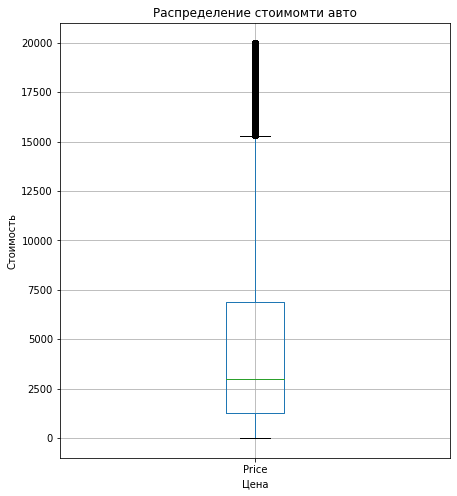

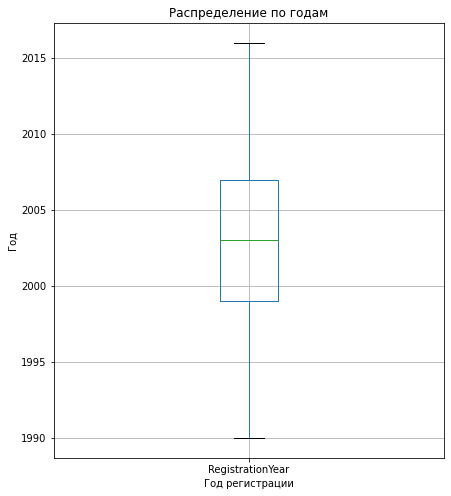

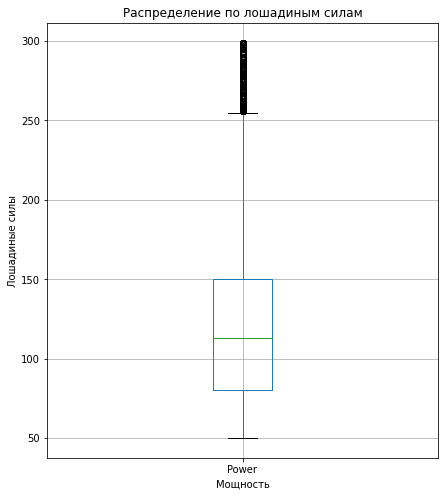

In [ ]:
columns = ['Price', 'RegistrationYear', 'Power']
title = ['Распределение стоимомти авто', 'Распределение по годам', 'Распределение по лошадиным силам']
y = ['Стоимость', 'Год', 'Лошадиные силы']
x = ['Цена', 'Год регистрации', 'Мощность']

for i in range(len(columns)):
    df.boxplot(columns[i], figsize=(7,8))
    plt.title(title[i])
    plt.ylabel(y[i])
    plt.xlabel(x[i])
    plt.show()

Лошадиные силы можно еще сократить, выставить ограничение до 255. Так же ограничим цены до 15000 евро, нижнюю границу проведем от 500 евро.

In [ ]:
df = df.loc[data['Power'] < 255]
df = df.loc[data['Price'] < 15000]
df = df.loc[data['Price'] > 500]

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 246751 entries, 2 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        246751 non-null  object
 1   Price              246751 non-null  int64 
 2   VehicleType        239187 non-null  object
 3   RegistrationYear   246751 non-null  int64 
 4   Gearbox            242866 non-null  object
 5   Power              246751 non-null  int64 
 6   Model              238912 non-null  object
 7   Kilometer          246751 non-null  int64 
 8   RegistrationMonth  246751 non-null  int64 
 9   FuelType           235518 non-null  object
 10  Brand              246751 non-null  object
 11  Repaired           214071 non-null  object
 12  DateCreated        246751 non-null  object
 13  NumberOfPictures   246751 non-null  int64 
 14  PostalCode         246751 non-null  int64 
 15  LastSeen           246751 non-null  object
dtypes: int64(7), object(

Удалим лишние колонки

In [ ]:
df = df.drop(['DateCrawled', 'RegistrationMonth', 'DateCreated', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'],
             axis=1)
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no


Теперь займемся оставшимися пропусками.

In [ ]:
df.isna().sum()

Price                   0
VehicleType          7564
RegistrationYear        0
Gearbox              3885
Power                   0
Model                7839
Kilometer               0
FuelType            11233
Brand                   0
Repaired            32680
dtype: int64

In [ ]:
pd.DataFrame(round(df.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
Price,0.000000
VehicleType,3.000000
RegistrationYear,0.000000
Gearbox,2.000000
Power,0.000000
Model,3.000000
Kilometer,0.000000
FuelType,5.000000
Brand,0.000000
Repaired,13.000000


Итак, у нас осталось не так много пропусков. Тип автомобильного кузова не указан в 3% данных, жалко терять 7564 строк, но достоверно заменить их достаточно трудоемко, поэтому заменим на unknown. Тип коробки передач так же важный показатель в определении цены, достоверно заменить фактически невозможно, так же поставим unknown. Модель важный показатель в определении цены, достоверно его заменить невозможно, придется поставить unknown. Тип топлива невозможно заменить достоверно, подлежит замене на unknown. Была ли машина в ремонте не указан в 13% записей. С уверенностью можно сказать, что все поддержаные машины были в ремонте, неудивительно, что это скрывют многие продавцы. А остальные пропуски удалим.

In [ ]:
df['VehicleType'] = df['VehicleType'].fillna('unknown')
df['Gearbox'] = df['Gearbox'].fillna('unknown')
df['Model'] = df['Model'].fillna('unknown')
df['FuelType'] = df['FuelType'].fillna('unknown')
df['Repaired'] = df['Repaired'].fillna('yes')

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 246751 entries, 2 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             246751 non-null  int64 
 1   VehicleType       246751 non-null  object
 2   RegistrationYear  246751 non-null  int64 
 3   Gearbox           246751 non-null  object
 4   Power             246751 non-null  int64 
 5   Model             246751 non-null  object
 6   Kilometer         246751 non-null  int64 
 7   FuelType          246751 non-null  object
 8   Brand             246751 non-null  object
 9   Repaired          246751 non-null  object
dtypes: int64(4), object(6)
memory usage: 20.7+ MB


Заменили данные пропуски на unknown, а в колонке с ремонтом на да.

Мы проанализировали наш датасет. Посмотрели его размер, отбросили выбросы, которые помешают во время машинного обучения. Так же удалили лишние столбцы. Обработали пропуски, заменив на неизвестное, а в колонках с ремонтом на да.

## Обучение моделей

Разделим и закодируем выборки

In [ ]:
features = df.drop(['Price'],axis=1)
target = df['Price']

features.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
2,suv,2004,auto,163,grand,125000,gasoline,jeep,yes
3,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
6,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no


In [ ]:
train_features, test_features, train_target, test_target = train_test_split(
    features,
    target,
    test_size = 0.25,
    random_state = 12345)

In [ ]:
test_features.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
63105,small,2004,manual,64,polo,150000,petrol,volkswagen,no
142142,sedan,2002,manual,102,a3,150000,petrol,audi,no
117178,wagon,1997,auto,160,unknown,150000,unknown,chrysler,yes
184791,sedan,1996,manual,116,golf,150000,petrol,volkswagen,no
207118,small,2007,manual,68,aygo,60000,petrol,toyota,no


In [ ]:
columns = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']

train_features_oe = train_features.copy()
test_features_oe = test_features.copy()

encoder = OrdinalEncoder()
encoder.fit(train_features_oe[columns])

train_features_oe[columns] = encoder.transform(train_features_oe[columns])
test_features_oe[columns] = encoder.transform(test_features_oe[columns])

train_features_oe.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
37242,8.0,1999,1.0,101,223.0,150000,2.0,24.0,1.0
245120,4.0,1995,1.0,140,11.0,150000,6.0,2.0,0.0
324265,8.0,2008,1.0,105,162.0,100000,2.0,31.0,0.0
140254,5.0,2005,1.0,68,147.0,90000,6.0,3.0,1.0
31345,4.0,2014,1.0,69,100.0,5000,6.0,31.0,0.0


Создадим функцию подсчета и для крос валидации

In [ ]:
def rmse(test_target, prediction):
    return mean_squared_error(test_target, prediction) **0.5

In [ ]:
rmse_scorer = make_scorer(rmse)

Разберем две модели: лес и LightGBM.

Начнем с леса.

Посмотрим на скорость обучения, потом на скорость работы и оценим результат.

In [ ]:
best_scores_forest = 20000
for estimators in range(40,161,20):
    model_forest = RandomForestRegressor(n_estimators=estimators,
                                                 random_state=12345).fit(train_features_oe,train_target)
    rmse = cross_val_score(model_forest,
                                          train_features_oe,
                                          train_target,
                                          scoring = rmse_scorer,
                                          cv = 3)
    scores_forest = np.mean(rmse)
    if scores_forest < best_scores_forest:
        best_scores_forest = scores_forest
        best_model_forest = model_forest
        best_estimators = estimators
print()
print(f"Лучшая модель при количестве деревьев 160, с оценкой 1346.734153316124")
print()


Лучшая модель при количестве деревьев 160, с оценкой 1346.734153316124



Оценим время работы лучшей модели леса

In [ ]:
start = time()
rmse = cross_val_score(best_model_forest,
                       train_features_oe,
                       train_target,
                       scoring = rmse_scorer,
                       cv = 3)

end = time()

forest_time = (end-start) /60
print(f'Время работы леса {forest_time}')

Время работы леса 2.7092087427775065


Посмотрим на работу LightGBM.

In [ ]:
best_scores_lgbm = 20000
for estimators in range(800, 1101, 200):
    for rate in range(2, 5, 2):
        rate = rate/10
        model_lgbm = LGBMRegressor(n_estimators=estimators,
                                   random_state=12345,
                                   learning_rate=rate,
                                   objective='rmse')

        rmse = cross_val_score(model_lgbm,
                                          train_features_oe,
                                          train_target,
                                          scoring = rmse_scorer,
                                          cv = 3)
        scores_lgbm = np.mean(rmse)
        if scores_lgbm < best_scores_lgbm:
            best_scores_lgbm = scores_lgbm
            best_model_lgbm = model_lgbm
            best_estimators = estimators
            best_rate = rate

print(f'''
Лучшая модель при количестве деревьев {best_estimators},
скоросью обучения {best_rate} с оценкой {best_scores_lgbm}
''')


Лучшая модель при количестве деревьев 1000, 
скоросью обучения 0.2 с оценкой 1271.8545851979122



In [ ]:
start = time()
best_model_lgbm = LGBMRegressor(n_estimators=1000,
              random_state=12345,
              learning_rate=0.2,
              objective='rmse')

rmse = cross_val_score(best_model_lgbm,
                                          train_features_oe,
                                          train_target,
                                          scoring = rmse_scorer,
                                          cv = 3)

end = time()

lgbm_time = (end-start) /60
print(f'Время работы лучшей модели бустинга {lgbm_time}')

Время работы лучшей модели бустинга 1.3


Мы посмотрели как работают 2 наших модели, случайный лес оказался явным аутсайдером, LightGBM фаворит.


Сведем все в таблицу и сравним результаты.

## Анализ моделей

Сделаем таблицу в которую внесем показатель rmse и время.

In [ ]:
results = {
    'Model' : ['RandomForestRegressor', 'LGBMRegressor'],
    'RMSE' :pd.Series([best_scores_forest, best_scores_lgbm]),
    'Time prediction': pd.Series([forest_time, lgbm_time]),
    }
display(pd.DataFrame(results))

,Model,RMSE,Time prediction
0,RandomForestRegressor,1346.734153,2.4
1,LGBMRegressor,1271.854585,1.3


Работа леса заняла 2,4 минут, у бустинга 1,3 минуты. Так же стоит отметить, что бустинг точнее почти на 100 евро. Выбор логично сделать в пользу бустинга.

Посмотрим работу бустинга на тестовой выборке.

In [ ]:
model_lgbm = LGBMRegressor(n_estimators=1000,
                                   random_state=12345,
                                   learning_rate=0.2,
                                   objective='rmse').fit(train_features_oe, train_target)
start = time()
prediction = model_lgbm.predict(test_features_oe)
end = time()
time = (end-start) /60
rmse = mean_squared_error(test_target, prediction) **0.5
print(f'Метрика качества равна {rmse}')

Метрика качества равна 1258.6204038078754


На тестовой выборке результат даже немного лучше. А время предсказания занимает мало времени.

In [ ]:
model_dummy = DummyRegressor(strategy="median")
model_dummy = model_dummy.fit(train_features_oe, train_target)
prediction = model_dummy.predict(test_features_oe)
rmse = mean_squared_error(test_target, prediction) **0.5
print(f'Метрика качества константной модели равна {rmse}')

Метрика качества константной модели равна 3820.95023285623


Метрика константной модели выше метрики лучшей модели - наша модель адекватна.

Таким образом, мы проанализировали датасет с данными про авто. Мы убрали выбросы и дубликаты. Так же, нулевые значения заменили на неизвестные, где невозможно достоверно понять как их заменить. В колонке был ли ремонт пустые значения мы заменили на "да", так как все машины были в ремонте. Позже мы создали три модели предсказания цены на авто. Последняя модель была использована для проверке на адекватность остальных моделей. Наилучший показатель у LGBMRegressor, второе место занял RandomForestRegressor. Для заказчика важны время и точность, поэтому лучшим и однозначным выбором становится бустинг.